In [12]:

import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from IPython.display import clear_output
tfds.disable_progress_bar()

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

import tensorflow_addons as tfa
import matplotlib.pyplot as plt

Я выбрал датасет оксфордских цветов, для классификации.
Качаем претрейн сверточную модель InceptionV3, так как своя свертка показала очень плохие результаты в районе 20 процентов, без аугментации(с ней было бы побольше). У нас 102 класса цветов. Трей и тест по 1000 примеров. 

In [14]:
pre_trained_model = InceptionV3(include_top=False, weights= 'imagenet', input_shape=(picture_size[0],picture_size[1],3))
pre_trained_model.trainable = False

Качаем датасет

In [16]:
ds_names_clf = 'oxford_flowers102'
dataset_c, info_c = tfds.load(ds_names_clf, split = ['train', 'validation'],with_info=True)

Смотрим инфо, ничего интересного =).

In [17]:
info_c

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

Я выбрал оксфордские цветы в качесте датасета, и буду делать классификацию.

In [18]:
lables = set()
for example in dataset_c[0]:
    lables.add(int(np.array(example['label'])))
print(min(lables), max(lables))
for example in dataset_c[0].take(5):
    print(example['image'].shape)


0 101
(500, 667, 3)
(500, 666, 3)
(670, 500, 3)
(500, 505, 3)
(500, 672, 3)


У нас разного размера картинки. что не очень хороши нужно их заресайзить в 1 размер. c лейблами все ок у нас 102 класса.

In [ ]:
picture_size =(288,288)

нормализуем картинки

In [20]:
def normalize_c(input_image, label):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, label

тут у нас ресайз картинки в (288, 288).

так же ImageDataGenerator как я понял в интернетах не работает с tfds.Dataset. Его советовали применять через map(), а потом через repeat() увеличить датасет.
тут я выбрал флип каждой второй картинки, и редкие изменения якрости насыщенности и небольшой поворт на 5 градусов, большие повороты сильно искахают картинку.

In [21]:
def load_image_train_c(datapoint):
  input_image = tf.image.resize(datapoint['image'], picture_size)
  label = datapoint['label']

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)

  if tf.random.uniform(()) > 0.85:
    input_image = tf.image.random_saturation(input_image, lower=0, upper=5)

  if tf.random.uniform(()) > 0.85:
    input_image = tf.image.random_brightness(input_image, 0.1)
  
  if tf.random.uniform(()) > 0.85:
    input_image = tfa.image.rotate(input_image, tf.random.uniform(()) * 10-5, fill_mode='nearest')
    

  input_image, label = normalize_c(input_image, label)

  return input_image, label

def load_image_test_c(datapoint):
  input_image = tf.image.resize(datapoint['image'], picture_size)
  input_mask = label = datapoint['label']

  input_image, label = normalize_c(input_image, label)

  return input_image, label 

Тут мы применяем map() и repeat() 5 раз, трейн стал в 5 раз длиннее, аугментированным.

In [22]:
train = dataset_c[0].map(load_image_train_c).repeat(5)
test = dataset_c[1].map(load_image_test_c)

так выглядят примеры картинок, меняются не сильно, кроме флипа на 180.

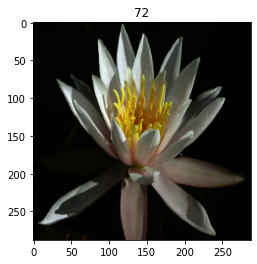

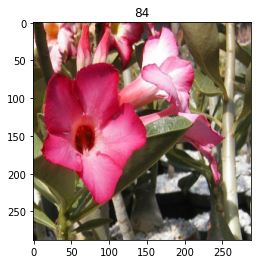

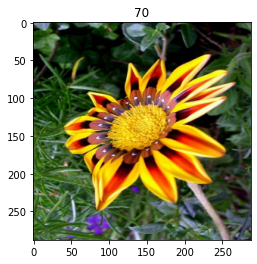

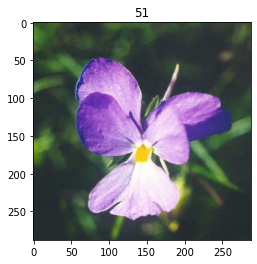

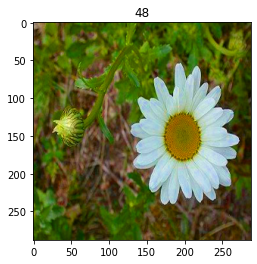

In [25]:
for image, label in train.take(5):
  sample_image, sample_label = image, label
  plt.imshow(sample_image.numpy()[:,:,:])
  plt.title(sample_label.numpy())
  plt.show()

In [27]:
BATCH_SIZE = 16
BUFFER_SIZE = 128

Кешим, батчим, шафлим. поговаривают увеличивает скорость.

In [29]:

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

в одном батче 16 картинок

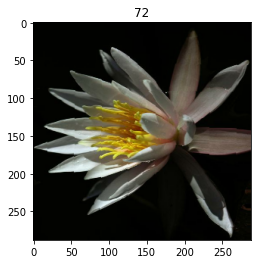

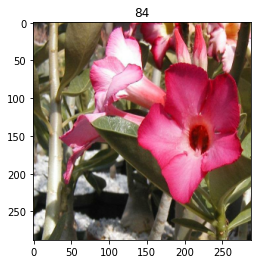

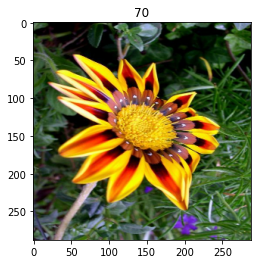

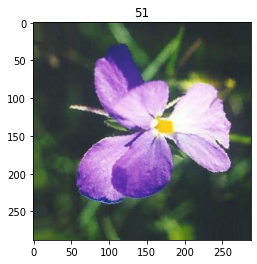

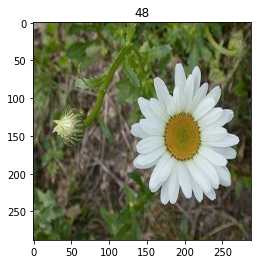

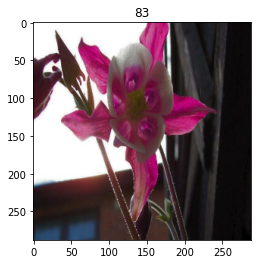

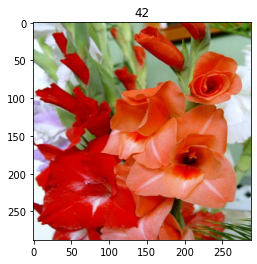

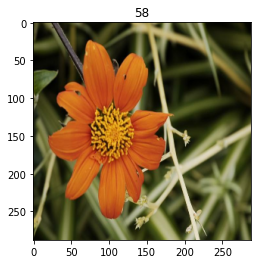

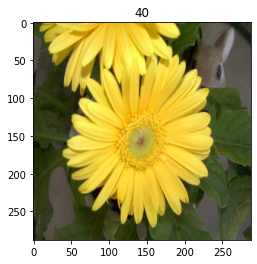

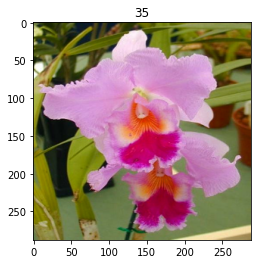

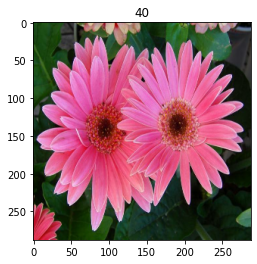

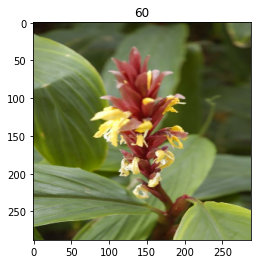

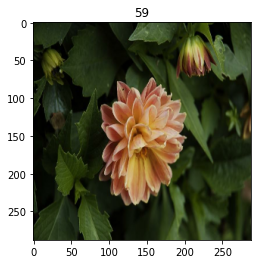

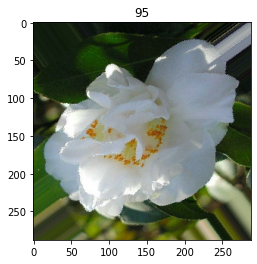

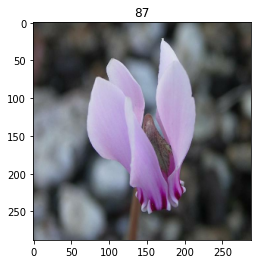

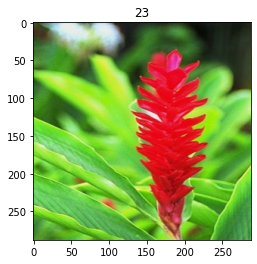

In [33]:
for image, label in train_dataset.take(1):
  
  sample_image, sample_label = image, label
  for i in range(BATCH_SIZE):
    plt.imshow(sample_image.numpy()[i,:,:,:])
    plt.title(sample_label.numpy()[i])
    plt.show()

батчим тест, что бы потом проверть на нем 

In [34]:
test_dataset = test.batch(BATCH_SIZE)

Собираем модель, в следствии большого числа экспериментов(ксожалению их тут нету). Так как большинство из них проводилось в попытке что бы это все заработало нормально. В общем была выбрана претренерованые сверточные слои InceptionV3(их там чуть меньше чем бесконечно много). И два полносвязных слоя 1024 ядрами, нормализацией и dropout = 0.5 для того что бы модель не переробучалась.

In [43]:
l_dim = 102
image_size = (image_size[0], image_size[1], 3)

e_inputs = keras.Input(shape=image_size)
x = pre_trained_model(e_inputs)
x = layers.Flatten()(x)

x = layers.Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dropout(.5)(x)

x = layers.Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dropout(.5)(x)

x = layers.Dense(l_dim)(x)

model = keras.Model(e_inputs,x, name="classifier")



model.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 288, 288, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 7, 7, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              102761472 
_________________________________________________________________
batch_normalization_188 (Bat (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1

loss  выбран в связ с тем что мы не делали OHE для ответов.

In [46]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits='True'), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

Опять же хоть тут этого и нету, но модель все же немного переобучается после 5-7 эпох и начинает терять точность на тесте. так что выбрано 5 эпох. А по сути это 25 эпох так как у нас данные трена аугметированы в 5 раз.

In [48]:
model.fit(train_dataset, epochs=6, batch_size=128)

Epoch 1/6
319/319 [==============================] - 62s 169ms/step - loss: 2.5845 - accuracy: 0.4151
Epoch 2/6
319/319 [==============================] - 53s 165ms/step - loss: 0.6154 - accuracy: 0.8353
Epoch 3/6
319/319 [==============================] - 54s 169ms/step - loss: 0.3640 - accuracy: 0.9045
Epoch 4/6
319/319 [==============================] - 56s 177ms/step - loss: 0.3562 - accuracy: 0.9051
Epoch 5/6
319/319 [==============================] - 55s 174ms/step - loss: 0.2711 - accuracy: 0.9292
Epoch 6/6
319/319 [==============================] - 56s 174ms/step - loss: 0.2577 - accuracy: 0.9312


In [49]:
model.evaluate(test_dataset)

64/64 [==============================] - 8s 95ms/step - loss: 1.4500 - accuracy: 0.6667


[1.4499677419662476, 0.6666666865348816]

В итоге мы получили точность модели порядка 0.6667. Кроссвалидацию я сделать уже не успею, но по ощущениям презапуск дает +-1.5 процента точности.
К сожалению слишком долго разбирался в процессе всего этого запуска. И в том как работает Dataset прошел все стадии от ненависти до принятия и смерения =). Этот ноутбук содержит не очень много исследований. Но у него есть 4 предшественника, которых пробовались другие варианты решения.

Основной вывод который я сделал, что Претрен модели дают гигансткий буст, такое дома не натренеруешь.